# Z Trigger efficiency study

In [ ]:

from hist import Hist
from hist.intervals import clopper_pearson_interval
import vector


In [1]:





import sys

## Always run these

In [1]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union, List

def check_selector(sample: str, selector: Union[str, List[str]]):
    if isinstance(selector, list) or isinstance(selector, tuple):     # If selector is a list or tuple
        
        for s in selector:     # Iterate over the list or tuple
            if s.startswith("*"):     # If selector starts with '*', check if the rest of the selector is in sample
                if s[1:] in sample:
                    return True
            else:
                if sample.startswith(s):
                    return True
    else:   # If selector is a single string
        if selector.startswith("*"):
            if selector[1:] in sample:
                return True
        else:
            if sample.startswith(selector):
                return True

    return False

In [13]:
from os.path import exists
# Define the output directory where plots will be saved
y = "2023"
output_dir = f"plots/{y}/"

# Create the output directory if it does not exist
import os
if not exists(output_dir):
    os.makedirs(output_dir)

### Starting the triggers dictionary and the histograms

In [4]:
trigger_dict = {
    "HLTs": (
        [            
            # offline triggers
            "QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65",
            "PFHT1050",
            "AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35",
            "AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35",
            "AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35",
            "AK8PFJet230_SoftDropMass40",
            "AK8PFJet425_SoftDropMass40",
            "AK8PFJet400_SoftDropMass40",
            "AK8DiPFJet250_250_MassSD50",
            "AK8DiPFJet260_260_MassSD30",
            "AK8PFJet420_MassSD30",
            "AK8PFJet230_SoftDropMass40_PNetBB0p06",
            "AK8PFJet230_SoftDropMass40_PNetBB0p10",
            "AK8PFJet250_SoftDropMass40_PNetBB0p06",
            
            # parking triggers
            
            # HHparking
            #"PFHT280_QuadPFJet30_PNet2BTagMean0p55",
            
            # VBFparking
            # https://its.cern.ch/jira/browse/CMSHLT-3058
            #"DiJet110_35_Mjj650_PFMET110",
            #"TripleJet110_35_35_Mjj650_PFMET110",
            #"VBF_DiPFJet80_45_Mjj650_PFMETNoMu85",
            #"VBF_DiPFJet110_35_Mjj650",
            #"VBF_DiPFJet110_35_Mjj650_TriplePFJet",
            #"VBF_DiPFJet110_40_Mjj1000_Detajj3p5",
            #"VBF_DiPFJet110_40_Mjj1000_Detajj3p5_TriplePFJet",
            #"VBF_DiJet_60_30_Mass500_DiJet50",
            #"VBF_DiJet_110_35_Mass620",
            
            # SingleMuonparking
            "Mu12_IP6",
        ],
        "label",
    ),
    
}

In [5]:
import hist
import numpy as np

# Define histogram axes and initialize histograms
ht_bins_fine = (25, 200, 2000)
zpt_axis = hist.axis.Regular(100, 0, 1000, name="pt", label=r"Z pT$^0$ [GeV]")
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
sdm_axis = hist.axis.Regular(100, 0, 1000, name="SDm", label=r"SD mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)
process_axis = hist.axis.StrCategory([], name="process_name", growth=True)

hpt_fj = hist.Hist(fjpt_axis, cat_axis, sample_axis, process_axis)
hpt_z = hist.Hist(zpt_axis, cat_axis, sample_axis, process_axis)
hsd = hist.Hist(sdm_axis, cat_axis, sample_axis, process_axis)


### Reading parquets and loading the samples

In [18]:
data_dir = "/Users/gbibim/Here/genZ"
#y = "2022"
y = "2023"
samples = {
    y: {
        #"Zto2Q-4Jets_LO": ["Zto2Q-4Jets_HT-400to600", "Zto2Q-4Jets_HT-600to800", "Zto2Q-4Jets_HT-800", "Zto2Q-4Jets_HT-200to400"],
        "Zto2Q-2Jets_NLO": ["Zto2Q-2Jets_PTQQ-100to200_1J", "Zto2Q-2Jets_PTQQ-200to400_1J", "Zto2Q-2Jets_PTQQ-400to600_1J", 
                        "Zto2Q-2Jets_PTQQ-600_1J", "Zto2Q-2Jets_PTQQ-100to200_2J", "Zto2Q-2Jets_PTQQ-200to400_2J", "Zto2Q-2Jets_PTQQ-400to600_2J", "Zto2Q-2Jets_PTQQ-600_2J" ],
        #"Zto2Nu-2Jets_NLO": ["Zto2Nu-2Jets_PTNuNu-100to200_1J", "Zto2Nu-2Jets_PTNuNu-200to400_1J", "Zto2Nu-2Jets_PTNuNu-400to600_1J", "Zto2Nu-2Jets_PTNuNu-600_1J", 
        #                 "Zto2Nu-2Jets_PTNuNu-100to200_2J", "Zto2Nu-2Jets_PTNuNu-200to400_2J", "Zto2Nu-2Jets_PTNuNu-400to600_2J", "Zto2Nu-2Jets_PTNuNu-600_2J"],
        #"Zto2Nu-4Jets_LO": ["Zto2Nu-4Jets_HT-100to200", "Zto2Nu-4Jets_HT-800to1500", "Zto2Nu-4Jets_HT-200to400", "Zto2Nu-4Jets_HT-400to800"],
    },
}[y]  #This is a way to retrieve the dictionary for the year "2022" from the dictionary of samples

events_dict = {}


In [19]:
import pandas as pd

for label, selector in samples.items():  #Iterating over the dictionary of samples. Label is the key and selector is the value associated with the key
    #label = Zto2Q-4Jets
    #selector = Zto2Q-4Jets_HT-400to600, Zto2Q-4Jets_HT-200to400, Zto2Q-4Jets_HT-600

    events_dict[label] = {}  # initiates an empty list for the label key in the events_dict dictionary
    print(selector)
    
    for sample in selector:
        events_dict[label][sample] = [] 
        if not check_selector(sample, selector):    # checks if the sample is in the selector list
            print(sample)
            continue
        if not exists(f"{data_dir}/{y}/{sample}/parquet"):    #checks if the parquet file exists
            print(f"No parquet file for {sample}")
            continue

        events = pd.read_parquet(f"{data_dir}/{y}/{sample}/parquet", columns=None)
        not_empty = len(events) > 0
        if not_empty:
            events_dict[label][sample] = events
        print(f"Loaded {sample: <50}: {len(events)} entries")

['Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J']
Loaded Zto2Q-2Jets_PTQQ-100to200_1J                      : 18998967 entries
Loaded Zto2Q-2Jets_PTQQ-200to400_1J                      : 7929898 entries
Loaded Zto2Q-2Jets_PTQQ-400to600_1J                      : 971914 entries
Loaded Zto2Q-2Jets_PTQQ-600_1J                           : 1043033 entries
Loaded Zto2Q-2Jets_PTQQ-100to200_2J                      : 18555240 entries
Loaded Zto2Q-2Jets_PTQQ-200to400_2J                      : 20014819 entries
Loaded Zto2Q-2Jets_PTQQ-400to600_2J                      : 1345579 entries
Loaded Zto2Q-2Jets_PTQQ-600_2J                           : 1023252 entries


#### Fill and save the 1D histograms

In [20]:
use_default_weight = False    # If True, the weight is set to 1 for all events

# Fill histograms for each sample
for label, sample_dict in events_dict.items():
    for sample_name, events in sample_dict.items():
        pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm_fj = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        
        selection = SDm_fj > 0  # Apply cuts here

        # Determine weight to use
        weight = 1 if use_default_weight else wd[selection]

        # Fill histograms for the sample
        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)
        hsd.fill(SDm=SDm_fj[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)

        # Fill histograms for each trigger category 
        for trigger_title, (triggers, trigger_label) in trigger_dict.items():
            #trigger_selection = np.zeros_like(selection, dtype=bool)
            for hlt in triggers:
                trigger_selection = np.zeros_like(selection, dtype=bool)    # this has to be outside the loop if we want to apply multiple triggers at the same time
                trigger_selection |= (events[hlt].values == 1).squeeze()    #Use bitwise OR (|=) to update trigger_selection to True wherever any trigger condition is met.
                                                                            # squeeze() removes any single-dimensional entries from the shape of the array.
                num_selection = trigger_selection & selection

                weight = 1 if use_default_weight else wd[num_selection]

                hpt_fj.fill(pt=pt_fj[num_selection], cat=hlt, sample_name=sample_name, process_name=label, weight=weight)
                hpt_z.fill(pt=pt_z[num_selection], cat=hlt, sample_name=sample_name, process_name=label, weight=weight)
                hsd.fill(SDm=SDm_fj[num_selection], cat=hlt, sample_name=sample_name, process_name=label, weight=weight)
                
                


## After filling all the histograms and samples you need, proceed with these

In [21]:
# Print a histo to check if you filled with all the samples needed
hpt_z.axes

(Regular(100, 0, 1000, name='pt', label='Z pT$^0$ [GeV]'),
 StrCategory(['denominator', 'PFHT1050', 'AK8PFJet230_SoftDropMass40', 'AK8PFJet425_SoftDropMass40', 'AK8DiPFJet250_250_MassSD50', 'AK8DiPFJet260_260_MassSD30', 'AK8PFJet420_MassSD30', 'AK8PFJet230_SoftDropMass40_PNetBB0p06', 'AK8PFJet230_SoftDropMass40_PNetBB0p10', 'AK8PFJet250_SoftDropMass40_PNetBB0p06'], growth=True, name='cat'),
 StrCategory(['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400', 'Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J'], growth=True, name='sample_name'),
 StrCategory(['Zto2Q-4Jets_LO', 'Zto2Q-2Jets_NLO'], growth=True, name='process_name'))

#### Save the histograms in a pickle file

In [22]:
import pickle
# Define a dictionary of histograms you want to save
histograms = {
    "hpt_z": hpt_z,
    "hpt_fj": hpt_fj,
    "hsd": hsd,
}

##### If you want to update an existing file

In [36]:
# Path to the pickle file
file_path = f'{output_dir}/histograms.pkl'

# Check if the file exists and load existing data if it does
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        existing_histograms = pickle.load(f)
else:
    existing_histograms = {}

# Update the existing data with new histograms
existing_histograms.update(histograms)

# Save the updated dictionary back to the pickle file
with open(file_path, 'wb') as f:
    pickle.dump(existing_histograms, f)

##### If you want to replace the file

In [23]:
# Path to the pickle file
file_path = f'{output_dir}/histograms.pkl'

# Save the updated dictionary back to the pickle file
with open(file_path, 'wb') as f:
    pickle.dump(histograms, f)

### Load histograms from the pickle file

In [2]:
import pickle
# Load the file
y = "2023"
output_dir = f"plots/{y}/"
with open(f'{output_dir}/histograms.pkl', 'rb') as f:
    histograms = pickle.load(f)



In [24]:
histograms["hpt_fj"]

Hist(
  Regular(100, 200, 1000, name='pt', label='fj pT$^0$ [GeV]'),
  StrCategory(['denominator', 'PFHT1050', 'AK8PFJet230_SoftDropMass40', 'AK8PFJet425_SoftDropMass40', 'AK8DiPFJet250_250_MassSD50', 'AK8DiPFJet260_260_MassSD30', 'AK8PFJet420_MassSD30', 'AK8PFJet230_SoftDropMass40_PNetBB0p06', 'AK8PFJet230_SoftDropMass40_PNetBB0p10', 'AK8PFJet250_SoftDropMass40_PNetBB0p06'], growth=True, name='cat'),
  StrCategory(['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400', 'Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J'], growth=True, name='sample_name'),
  StrCategory(['Zto2Q-4Jets_LO', 'Zto2Q-2Jets_NLO'], growth=True, name='process_name'),
  storage=Double()) # Sum: 5.001413607565875e+16 (9.485850525967365e+16 with flow)

### 1D Plots 

In [32]:
import matplotlib.pyplot as plt
import hist
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

In [51]:
def plot_1D(hist_to_plot, var, to_plot):

    hist = histograms[hist_to_plot]

    # Access categories explicitly
    #categories = hist.axes["process_name"]

    # Plot the histograms
    
    for label in to_plot:
        print(label)

        categories = hist.axes["sample_name"]
        proc_hist = None

        # Plot for each sample
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        for i, sample in enumerate(categories):

            h = hist[{"cat": "denominator", "sample_name": sample, "process_name": label}]
            # Filling for the stitched category
            if proc_hist is None:
                proc_hist = h.copy()
            else:
                if h.sum()==0:
                    continue
                else:
                    proc_hist += h

            hep.histplot(h, ax=ax, label=sample)
        ax.set_yscale("log")
        ax.legend()
        plt.title(f"{var} for {label}")
        plt.ylabel("Counts")
        plt.savefig(f"{output_dir}/{var}_samples_{label}.png")

        # Plot for the stiched category
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        hep.histplot(proc_hist, label=label)
        ax.set_yscale("log")
        #ax.legend()
        plt.title(f"{var} for {label}")
        plt.ylabel("Counts")
        plt.savefig(f"{output_dir}/{var}_{label}.png")  # Save the plot as a PNG file
        #plt.close(fig)  # Close the figure to free up memory
        proc_hist = None


In [34]:
def plot_compare(hist_to_plot, var, to_plot):

    # Load the file
    with open(f'{output_dir}/histograms.pkl', 'rb') as f:
        histograms = pickle.load(f)

    # Retrieve the histograms
    if hist_to_plot not in histograms:
        raise ValueError(f"Histogram {hist_to_plot} not found in the histograms dictionary")
    
    hist = histograms[hist_to_plot]

    # Access categories explicitly
    #categories = hist.axes["process_name"]

    # Plot the histograms
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for label in to_plot:      
        categories = hist.axes["sample_name"]  
        proc_hist = None
        for i, sample in enumerate(categories):
            h = hist[{"cat": "denominator", "sample_name": sample, "process_name": label}]
            # Filling for the stitched category
            if proc_hist is None:
                proc_hist = h.copy()
            else:
                proc_hist += h
        hep.histplot(proc_hist, label=label)
    ax.set_yscale("log")
    ax.legend()
    plt.title(f"{var} comparison")
    plt.ylabel("Counts")
    plt.savefig(f"{output_dir}/{var}__denominator_comparison.png")  # Save the plot as a PNG file
    #plt.close(fig)  # Close the figure to free up memory



In [57]:
h = histograms["hpt_z"][{"cat": "denominator", "sample_name": "Zto2Q-4Jets_HT-400to600", "process_name": "Zto2Q-2Jets_NLO"}]
h

Hist(Regular(100, 0, 1000, name='pt', label='Z pT$^0$ [GeV]'), storage=Double())

In [37]:
h = histograms["hpt_z"]
h.axes

(Regular(100, 0, 1000, name='pt', label='Z pT$^0$ [GeV]'),
 StrCategory(['denominator', 'PFHT1050', 'AK8PFJet230_SoftDropMass40', 'AK8PFJet425_SoftDropMass40', 'AK8DiPFJet250_250_MassSD50', 'AK8DiPFJet260_260_MassSD30', 'AK8PFJet420_MassSD30', 'AK8PFJet230_SoftDropMass40_PNetBB0p06', 'AK8PFJet230_SoftDropMass40_PNetBB0p10', 'AK8PFJet250_SoftDropMass40_PNetBB0p06'], growth=True, name='cat'),
 StrCategory(['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400', 'Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J'], growth=True, name='sample_name'),
 StrCategory(['Zto2Q-4Jets_LO', 'Zto2Q-2Jets_NLO'], growth=True, name='process_name'))

Zto2Q-4Jets_LO
Zto2Q-2Jets_NLO


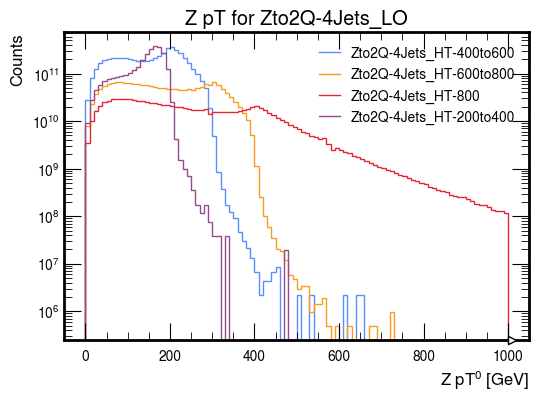

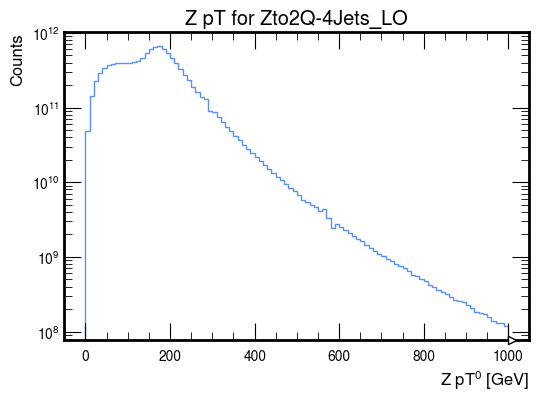

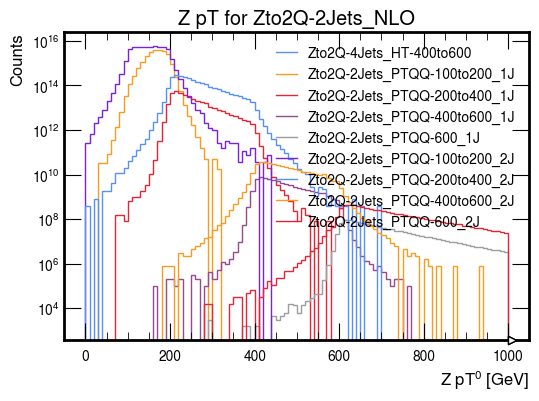

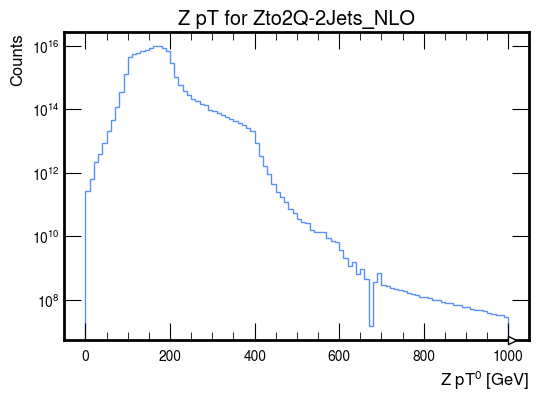

In [53]:
plot_this = ["Zto2Q-4Jets_LO", "Zto2Q-2Jets_NLO"]

# Generate and save plots
plot_1D("hpt_z", "Z pT", plot_this)

# Maybe make the process one of the inputs so I can pick the one I want to plot

#plot_compare("hpt_z", "Z pT", plot_this)


#### Checking the triggers

QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65


NameError: name 'hpt_h' is not defined

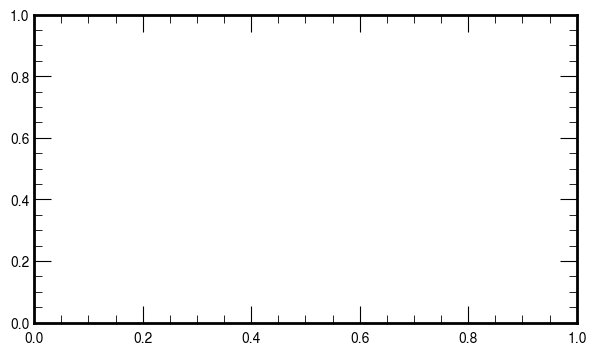

In [46]:
# comparing the triggers
sample = "HHto4B"
label = "HHto4B"
fig, ax = plt.subplots(1, 1, figsize=(7, 4))    
for trigger_title, (triggers, trigger_label) in trigger_dict.items():
    for hlt in triggers:
        print(hlt)
        try:
            #h = hpt_z[{"cat": hlt, "sample_name": sample, "process_name": label}]   
            h = hpt_h[{"cat": hlt, "sample_name": sample, "process_name": label}]   
            hep.histplot(h, label=hlt, ax=ax, flow="none")
        except KeyError:
            print(f"KeyError: '{hlt}' not found in the histogram dictionary.")
            continue
        #hep.histplot(hpt_z[{"cat": hlt, "sample_name": sample, "process_name": label}], ax=ax, label=hlt)
    #hep.histplot(hpt_z[{"cat": trigger_title, "sample_name": "Zto2Q-2Jets", "process_name": "Zto2Q-2Jets"}], ax=ax, label=trigger_title)
plt.title(f"pT Denominator - {label}")
ax.legend()

### Efficiency

In [55]:
import matplotlib.pyplot as plt

def plot_eff(hist_to_plot, sample, sample_label, output_dir, var):
    """
    Plot triggers efficiency histograms and save them to files.
    
    Args:
        hist_to_plot (dict): Dictionary of histograms to plot.
        sample (str): Sample name.  ie. "Zto2Q-4Jets_HT-400to600"
        sample_label (str): Label for the sample. ie. "Zto2Q-4Jets"
        output_dir (str): Directory where the plots will be saved.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))   #efficiency plot

    for trigger_title, (triggers, trigger_label) in trigger_dict.items():
        for hlt in triggers:
            try:
                den = hist_to_plot[{"cat": "denominator", "sample_name": sample, "process_name": sample_label}]
                num = hist_to_plot[{"cat": hlt, "sample_name": sample, "process_name": sample_label}]
                
                with np.errstate(divide='ignore', invalid='ignore'):
                    ratio = np.divide(num, den)#, where=den_view!=0)

                #print(f"Ratio for {hlt}: {ratio}")

                hep.histplot(
                    num/den,
                    #ratio,
                    #yerr=abs((clopper_pearson_interval(num.view(), den.view()) - num.view() / den.view())),
                    label=hlt,
                    ax=ax,
                    flow="none",
                )
            except KeyError:
                print(f"KeyError: '{hlt}' not found in the histogram dictionary.")
                continue
            
    ax.legend()

    ax.set_ylabel("Signal Trig. Eff.")
    ax.set_ylim(0, 1)
    ax.set_xlabel(var)
    plt.title(f"Signal Trigger Efficiency for {sample}")
    
    # Save the plot
    plt.savefig(f"{output_dir}/{y}/{var}_signal_trigger_efficiency_{sample}.png")
    #plt.close(fig)

# Define the output directory where plots will be saved
output_dir = "plots"

# Create the output directory if it does not exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



In [77]:
for axis in hpt_z.axes:
    print(f"Axis: {axis}")

Axis: Regular(100, 0, 1000, name='pt', label='Z pT$^0$ [GeV]')
Axis: StrCategory([], growth=True, name='cat')
Axis: StrCategory([], growth=True, name='sample_name')
Axis: StrCategory([], growth=True, name='process_name')


KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'PFHT1050' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8PFJet425_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8PFJet400_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8DiPFJet250_250_MassSD50' not found in the histogram dictionary.
KeyError: 'AK8DiPFJet260_260_MassSD30' not found in the histogram dictionary.
KeyError: 'AK8PFJet420_MassSD30' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PNetBB0p06' not found in the histo

/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_19801/2935417285.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'PFHT1050' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8PFJet425_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8PFJet400_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8DiPFJet250_250_MassSD50' not found in the histogram dictionary.
KeyError: 'AK8DiPFJet260_260_MassSD30' not found in the histogram dictionary.
KeyError: 'AK8PFJet420_MassSD30' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PNetBB0p06' not found in the histo

/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_19801/2935417285.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


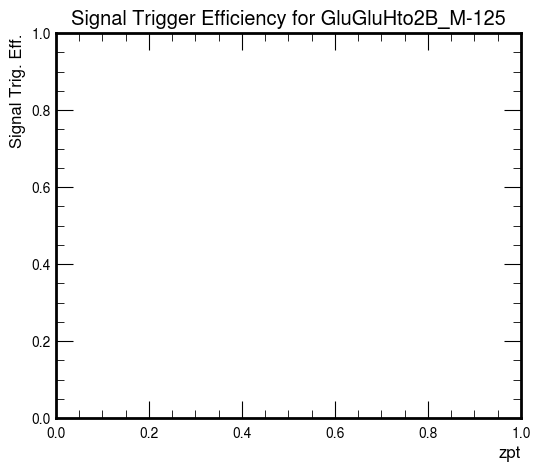

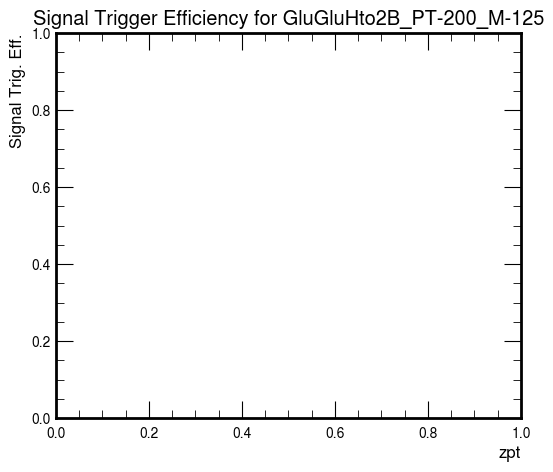

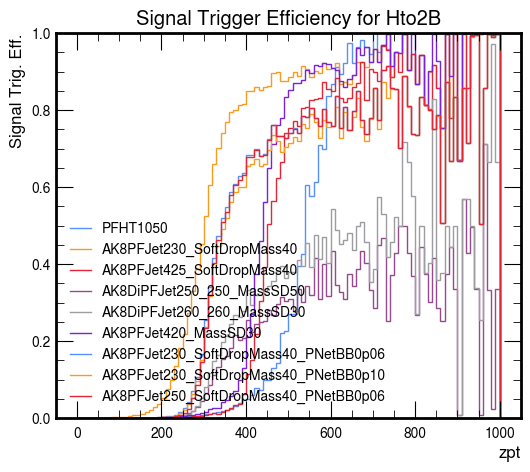

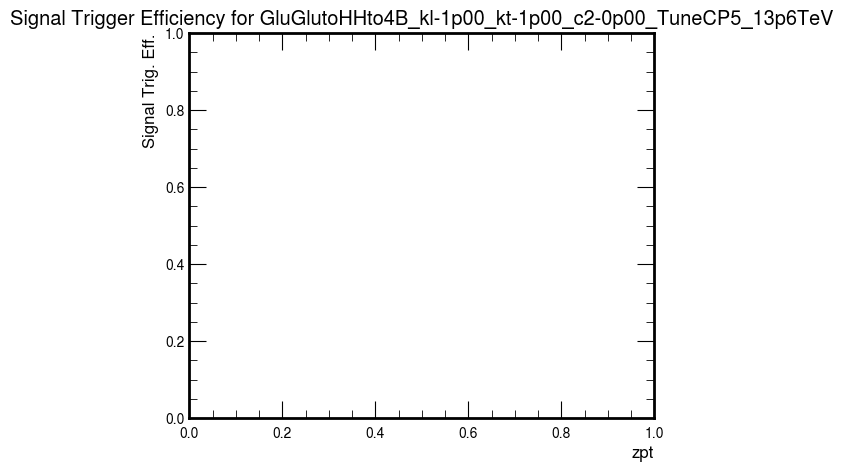

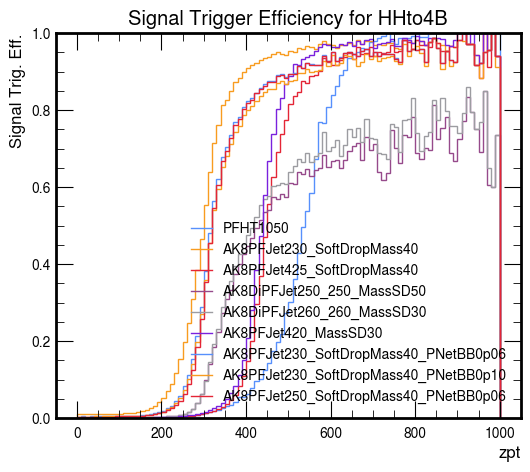

In [56]:
# Generate and save plots

for label, selector in samples.items():
    for sample in selector:
        plot_eff(hpt_z, sample, label, output_dir, var="zpt")
        #plot_eff(hsd, sample, label, output_dir, var="SDm")
        #plot_eff(hpt_fj, sample, label, output_dir, var="fjpt")

    #plot_eff(hpt_z, label, label, output_dir, var="zpt")
    plot_eff(hpt_h, label, label, output_dir, var="zpt")
    #plot_eff(hsd, label, label, output_dir, var="SDm")
    #plot_eff(hpt_fj, label, label, output_dir, var="fjpt")

### 2D hist of FatJetPt and SoftDropMass


In [58]:
import hist
import matplotlib.pyplot as plt
import numpy as np

# Define the axes
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
SDm_axis = hist.axis.Regular(100, 0, 300, name="SDm", label="Soft Drop Mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)

# Create the histogram
h2d = hist.Hist(fjpt_axis, SDm_axis, cat_axis, sample_axis)

In [73]:
# Filling the histogram

for label, sample_dict in events_dict.items():
    for sample_name, events in sample_dict.items():
        #pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm_fj = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        
        selection = SDm_fj > 40

        # For separated samples
        #h2d.fill(pt=pt_0[selection], cat="denominator", sample_name=sample, weight=wd[selection])
        #h2d.fill(pt=pt_0, SDm=SDm_0 cat="denominator", sample_name=sample) #no weight or cuts

        #for all samples
        h2d.fill(pt=pt_fj, SDm=SDm_fj, cat="denominator", sample_name=label, weight=wd) #no weight or cuts
        for trigger_title, (triggers, trigger_label) in trigger_dict.items():
            trigger_selection = np.zeros_like(selection)
            for hlt in triggers:
                trigger_selection |= (events[hlt].values == 1).squeeze()
            num_selection = trigger_selection
            #hpt.fill(pt=pt_0[num_selection & selection], cat=trigger_title, sample_name=sample, weight=wd[num_selection & selection])
            #hpt.fill(pt=pt_0[num_selection & selection], cat=trigger_title, sample_name="todas", weight=wd[num_selection & selection])

            #h2d.fill(pt=pt_0[num_selection], SDm=SDm_0[num_selection], cat=trigger_title, sample_name=sample)
            h2d.fill(pt=pt_fj[num_selection], SDm=SDm_fj[num_selection], cat=hlt, sample_name=label, weight=wd[num_selection])


KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'PFHT1050' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8PFJet425_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8PFJet400_SoftDropMass40' not found in the histogram dictionary.
KeyError: 'AK8DiPFJet250_250_MassSD50' not found in the histogram dictionary.
KeyError: 'AK8DiPFJet260_260_MassSD30' not found in the histogram dictionary.
KeyError: 'AK8PFJet420_MassSD30' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PNetBB0p06' not found in the histo

/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_19801/2786292362.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


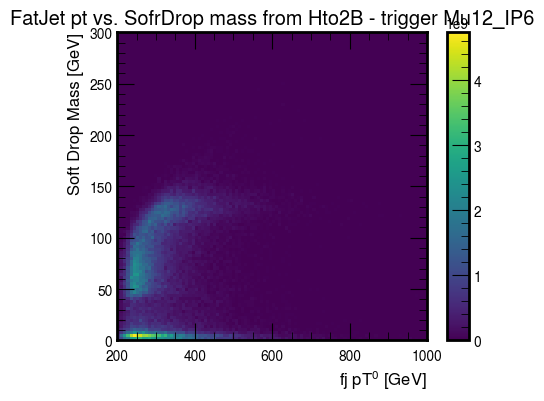

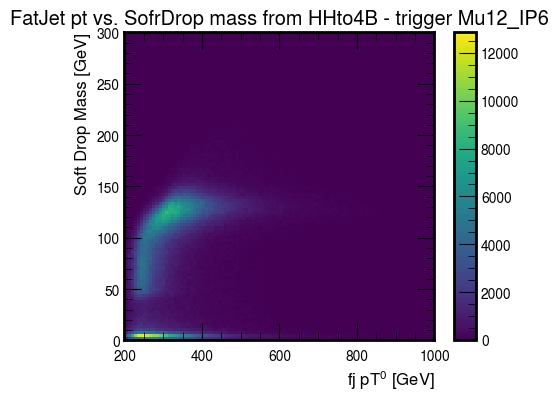

In [76]:
for label, selector in samples.items():
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    for trigger_title, (triggers, trigger_label) in trigger_dict.items():
        for hlt in triggers:
            try:
                hep.hist2dplot(h2d[{"cat": hlt, "sample_name": label}], ax=ax, flow="none")
            except KeyError:
                print(f"KeyError: '{hlt}' not found in the histogram dictionary.")
                continue
        ax.legend()
    #leg = ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.title(f"FatJet pt vs. SofrDrop mass from {label} - trigger {hlt}")

    # Save the plot
        plt.savefig(f"{output_dir}/fjpt_vs_SDm_{label}_withWeight_withtrigger{trigger_title}.png")
    #plt.close(fig)